In [39]:
import os
import re
import requests
from zipfile import ZipFile
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gp

- Import FARS data
- Cut person.csv to relevant attributes
- Cut accident.csv to relevant attributes
- Join person.csv and accident.csv such that records in person.csv are maintained
- Spatially enable dataframe
- Import census tracts
- Write join count function
    - Join count total fatality points to census tracts, but keep census tracts where no fatalities occurred
    - Join count bike, ped, personal conveyance fatality points to census tracts, but keep census tracts where no fatalities occurred
- Write function to calculate relative fatalities
    - Calculate relative bike, ped, personal conveyance fatalities as attributes on census tracts

# Geographic Data

In [36]:
# citation: https://andrewpwheeler.com/2022/02/28/downloading-geo-files-from-census-ftp-using-python/
def get_zip(url):
    webpage = requests.get(url, verify=False)
    soup = BeautifulSoup(webpage.content,"html.parser")
    zip_files = soup.find_all("a", href=re.compile(r"zip")) # find anchor elements on page whose href contain "zip"
    zip_urls = [os.path.join(url, i["href"]) for i in zip_files] # join the webpage url to the file name for each file
    return zip_urls

url = r"https://www2.census.gov/geo/tiger/TIGER2021/TRACT/"
zips = get_zip(url)
dfs = [] # initialize empty list to hold tract geodataframes
for file in zips:
    dfs.append(gp.read_file(file)) # read in tract files and add to list
tracts = pd.concat(dfs) # combine tracts into single geodataframe
tracts.to_file("../data/raw/tracts.geojson", driver="GeoJSON") # export to local file

/opt/anaconda3/envs/gds/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [37]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727..."
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613..."
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543..."
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557..."
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820..."


<AxesSubplot:>

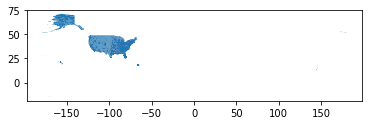

In [38]:
tracts.plot()

# FARS Data

In [57]:
person_cols = [
    "ST_CASE",
    "PER_TYP", # p.265 of 2022 User Manual PDF
    "PER_TYPNAME", # p.265 of 2022 User Manual PDF
    "INJ_SEV", # p.267 of 2022 User Manual PDF
    "INJ_SEVNAME" # p.267 of 2022 User Manual PDF
]

accident_cols = [
    "ST_CASE",
    "LATITUDE", # p.67 of User Manual PDF
    "LONGITUD" # p.68 of User Manual PDF
]

In [62]:
# citation: https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas
# this should work but doesn't

zip_file = ZipFile('../data/raw/FARS2020NationalCSV.zip')

# https://docs.python.org/3/library/codecs.html#error-handlers
# both files ran into decoding issues
accidents = pd.read_csv(zip_file.open("accident.CSV"), usecols=accident_cols, encoding_errors="surrogateescape")
person = pd.read_csv(zip_file.open("person.csv"), usecols=person_cols, encoding_errors="surrogateescape")

In [63]:
person.head()

,ST_CASE,PER_TYP,PER_TYPNAME,INJ_SEV,INJ_SEVNAME
0,10001,1,Driver of a Motor Vehicle In-Transport,4,Fatal Injury (K)
1,10001,2,Passenger of a Motor Vehicle In-Transport,3,Suspected Serious Injury (A)
2,10001,2,Passenger of a Motor Vehicle In-Transport,4,Fatal Injury (K)
3,10001,2,Passenger of a Motor Vehicle In-Transport,4,Fatal Injury (K)
4,10002,1,Driver of a Motor Vehicle In-Transport,3,Suspected Serious Injury (A)


In [64]:
accidents.head()

,ST_CASE,LATITUDE,LONGITUD
0,10001,32.433133,-86.094850
1,10002,33.484658,-86.839544
2,10003,33.299942,-86.369642
3,10004,33.795072,-85.883486
4,10005,32.848414,-86.083547


In [65]:
# join spatial data from accidents to person data
fars = person.merge(accidents, how="left", on="ST_CASE", validate="m:1")

In [66]:
fars.head()

,ST_CASE,PER_TYP,PER_TYPNAME,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD
0,10001,1,Driver of a Motor Vehicle In-Transport,4,Fatal Injury (K),32.433133,-86.094850
1,10001,2,Passenger of a Motor Vehicle In-Transport,3,Suspected Serious Injury (A),32.433133,-86.094850
2,10001,2,Passenger of a Motor Vehicle In-Transport,4,Fatal Injury (K),32.433133,-86.094850
3,10001,2,Passenger of a Motor Vehicle In-Transport,4,Fatal Injury (K),32.433133,-86.094850
4,10002,1,Driver of a Motor Vehicle In-Transport,3,Suspected Serious Injury (A),33.484658,-86.839544


In [100]:
# use lat/lon to create geometry
fars = gp.GeoDataFrame(fars, geometry=gp.points_from_xy(fars.LONGITUD, fars.LATITUDE), crs=4269)

<AxesSubplot:>

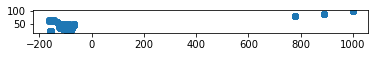

In [69]:
fars.plot()

In [101]:
# filter records to only fatal injuries
fars = fars.loc[fars["INJ_SEV"]==4]
fars

In [102]:
# lat/lon values signifiying not reported, unavailable, or reported as unknown
lat_vals = [77.7777000, 88.8888000, 99.9999000]
lon_vals = [777.7777000, 888.8888000, 999.9999000]

In [103]:
# check to see which records have invalid location information
invalid_loc = fars.loc[fars["LATITUDE"].isin(lat_vals) | fars["LONGITUD"].isin(lon_vals)]
invalid_loc

,ST_CASE,PER_TYP,PER_TYPNAME,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD,geometry


In [104]:
# remove records with invalid location info
fars = fars[~fars.isin(invalid_loc)].dropna(how = 'all')

<AxesSubplot:>

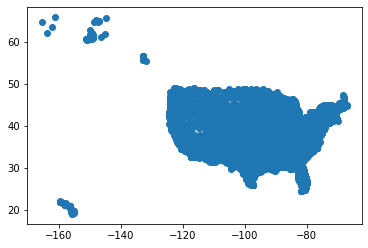

In [105]:
fars.plot()

In [ ]:
# unfinished


def join_count(points, polygons, groupby_col, count_name):
    join = points.sjoin(polygons, how="left", predicate="within")
    grouped = join.groupby(by=groupby_col)
    counts = grouped.size().reset_index()
    counts.rename({0: count_name}, inplace=True)
    

In [128]:
join = fars.sjoin(tracts, how="left", predicate="within")

In [129]:
grouped = join.groupby(by="GEOID")
grouped

In [130]:
counts = grouped.size().reset_index()
counts

,GEOID,0
0,01001020400,1
1,01001020700,1
2,01001020801,1
3,01001020803,1
4,01001020804,1
...,...,...
24526,56039967704,2
24527,56041975201,1
24528,56041975202,1
24529,56043000200,2


In [135]:
counts.rename({: "count"}, inplace=True)
tracts_copy = tracts
tracts_copy.merge(counts, on="GEOID", how="left")
#tracts_copy["0"].fillna(0, inplace=True)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,0
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727...",NaN
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613...",NaN
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543...",NaN
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557...",NaN
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85523,78,010,970500,78010970500,9705,Census Tract 9705,G5020,S,8281505,0,+17.7367518,-064.7453601,"POLYGON ((-64.75938 17.74196, -64.75857 17.742...",NaN
85524,78,010,970700,78010970700,9707,Census Tract 9707,G5020,S,15806699,143654,+17.7639765,-064.7888809,"POLYGON ((-64.82062 17.75921, -64.81715 17.760...",NaN
85525,78,010,970100,78010970100,9701,Census Tract 9701,G5020,S,28112089,3373334,+17.7495196,-064.6291392,"MULTIPOLYGON (((-64.62840 17.78893, -64.62836 ...",NaN
85526,78,010,970600,78010970600,9706,Census Tract 9706,G5020,S,11324382,833399,+17.7636903,-064.7571442,"MULTIPOLYGON (((-64.74933 17.78710, -64.74930 ...",NaN
